# Tensorflow tensor datastructure to build the same

In [1]:
# All posible imports
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.metrics import mean_squared_error

# Utility functions

In [52]:
# Utility function to plot 3D Graphs
def plot_3d(comp, title, X, y, y_pred=None):
    X_tnse = TSNE(n_components=comp, random_state=123).fit_transform(X)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    if y_pred is not None:
        ax.scatter(X_tnse[:,0], X_tnse[:,1], y_pred, label='y_pred', marker='v')
    ax.scatter(X_tnse[:,0], X_tnse[:,1], y, label='y_true')
    ax.set_title(title)
    plt.legend()
    plt.show()

# Generating Sample data 3 inputs & 2 output

In [53]:
n = 200

# We need to take 3 inputs
inputs_dimensions = 3

# We need to have 2 outputs
output_dimensions = 2

# Setup some random seed
tf.random.set_seed(3)

# Generating X with 3 dimentions
X = tf.random.uniform((n, inputs_dimensions), -1, 1)

# Generating the value of the y_true
weights_true = tf.constant([[2., -5., 9.], [-1., 4., -5.]], dtype=tf.float32)
bias_true = tf.constant([[1], [-1]], dtype=tf.float32)

y_true = tf.matmul(9 * X ** 2, weights_true, transpose_b=True) + tf.matmul(X, weights_true, transpose_b=True) + tf.transpose(bias_true)

print('Sample Value for X:' + str(X[:3]))
print('Sample Value for y:'+ str(y_true[:3]))

Sample Value for X:tf.Tensor(
[[-0.73267365  0.13570619 -0.00733662]
 [-0.9662695   0.00908351  0.4974625 ]
 [-0.73932624 -0.32877016  0.30385542]], shape=(3, 3), dtype=float32)
Sample Value for y:tf.Tensor(
[[  7.628318   -3.8585553]
 [ 40.346657  -22.020931 ]
 [ 16.35329    -8.277992 ]], shape=(3, 2), dtype=float32)


# Plotting the data in a 3-Dimentional Plane

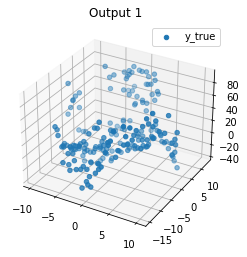

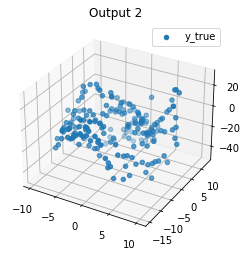

In [54]:
plot_3d(2, 'Output 1', X, y_true[:,0])
plot_3d(2, 'Output 2', X, y_true[:,1])

# Hyperparameters - Various Parameters that we will be using

In [25]:
# Number of Iterations
epochs = 200

# Learning rate of the algorithm
learning_rate = 0.01

# Inputs and outputs size. i.e 2 and 3 relatively
inputs = X.shape[1]
outputs = y_true.shape[1]

print("Number of inputs"+str(inputs))
print("Number of outputs"+str(outputs))

Number of inputs3
Number of outputs2


In [29]:
class Layer:
    def __init__(self, no_input_nodes=1, no_output_nodes=1, activation=None):
        self.no_input_nodes = no_input_nodes
        self.no_output_nodes = no_output_nodes
        # Init layer with random weights and bias
        self.weights = tf.random.uniform((no_input_nodes, no_output_nodes), -1, 1)
        self.bias = tf.random.uniform((1, 1), -1, 1)
        self.X = tf.zeros([no_input_nodes])
        # Set activation function
        if activation == 'relu':
            self.activation = Relu()
        else: 
            self.activation = None
  
    def forward(self, X):
        self.X = X
        self.Z = tf.matmul(X, self.weights) + tf.transpose(self.bias)
        # Pass output to activation function
        if self.activation == None:
            return self.Z 
        else:
            return self.activation.forward(self.Z)

    # Refered for math resource: https://www.kdnuggets.com/2019/08/numpy-neural-networks-computational-graphs.html
    def backward(self, upstream_gradient):
        curr_upstream_gradient = upstream_gradient
        # Perform backpropagation on activation function first before backpropagation on weight and bias gradient
        if self.activation != None:
            curr_upstream_gradient = self.activation.backward(curr_upstream_gradient)

        # Gradient of weights with respect to loss
        self.dJdW = tf.matmul(self.X, curr_upstream_gradient, transpose_a=True)
        # Constant Bias leads to upstream gradient to be the sum of gradients
        self.dJdb = tf.reduce_sum(curr_upstream_gradient, 1)
        # New Upstream to the prevoius layer
        self.dJdX = tf.matmul(curr_upstream_gradient, self.weights, transpose_b=True)
        return self.dJdX

    # Update weight and bias params with learning rate step size
    def update(self, lr):
        self.weights = self.weights - lr * self.dJdW
        self.bias = self.bias - lr * self.dJdb

    def __str__(self):
        return 'Layer: ({},{}) Activation Function: {}\nInputs:\n{}\nWeights:\n{}\nBias:{}'.format(self.no_input_nodes, self.no_output_nodes, self.activation, self.X[:2], self.weights, self.bias)

class Relu:
    def __init__(self):
        self.input = tf.constant([], dtype=tf.float32)

    def forward(self, input):
        self.input = input
        self.output = tf.clip_by_value(self.input, clip_value_min=0, clip_value_max=tf.float32.max)
        return self.output
  
    # If input is less than 0, derivative is 0. If input is greater than 0, derivative is 1
    def backward(self, upstream_gradient):
        return tf.where((self.input > 0), upstream_gradient, 0)
  
    # No update needed to ReLU members
    def update(self, lr):
        return

    def __str__(self):
        return 'ReLu'

class Model:
    def __init__(self, num_inputs=3, num_hidden=[2], num_outputs=2, activation=None):
        self.num_inputs = num_inputs
        self.num_hidden = num_hidden
        self.num_outputs = num_outputs

        layers = [self.num_inputs] + self.num_hidden + [self.num_outputs]

        self.layers = []
        for i in range(len(layers[:-1])):
          # Don't add activation function to last layer because this is a regression problem
            if i == len(layers[:-1]) - 1:
                self.layers.append(Layer(layers[i], layers[i + 1], activation=None))
            else:
                self.layers.append(Layer(layers[i], layers[i + 1], activation))

        print('Total number of Layers in the Neural Network')
        for i, layer in enumerate(self.layers):
            print('=== Layer {} ==='.format(i))
            print(layer)
        print()

    def forward(self, inputs):
        curr_out = inputs
        for l in self.layers:
          curr_out = l.forward(curr_out)
        return curr_out
  
    def backward(self, y_pred, y_true):
        # Start with gradient from loss function wrt prediction
        mse = MSE(y_pred, y_true)
        error = mse.get_error()
        print('Error: ', mean_squared_error(y_true, y_pred))
        loss_gradient = mse.backward()

        # Pass dJ/dy to last layer of network and compute gradients at each layer backwards
        gradient = loss_gradient
        for layer in reversed(self.layers):
            gradient = layer.backward(gradient)
    
    def update(self, lr):
        for layer in self.layers:
            layer.update(lr)

    # Training loop over # of epochs
    def fit(self, X, y_true, epochs):
        for i in range(epochs):
            y_pred = self.forward(X)
            self.backward(y_pred, y_true)
            self.update(learning_rate)

    def __str__(self):
        s = [str(layer) for layer in self.layers]
        return '\n'.join(s)

# Mean Squared Error
class MSE:
    def __init__(self, y_pred, y_true):
        self.y_pred = y_pred
        self.y_true = y_true
  
    def get_error(self):
        n = self.y_true.shape[0]
        return ((self.y_pred - self.y_true) ** 2) / n
  
    def backward(self):
        n = self.y_true.shape[0]
        self.gradient = 2.0 * (self.y_pred - self.y_true) / n
        return self.gradient

# Training with Activation function RELU

In [30]:
nn = Model(num_inputs=inputs, num_hidden=[4, 3], num_outputs=outputs, activation='relu')
nn.fit(X, y_true, epochs)
y_pred = nn.forward(X)

err = mean_squared_error(y_true, y_pred)
print('Final MSE: {}'.format(err))

Total number of Layers in the Neural Network
=== Layer 0 ===
Layer: (3,4) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[-0.84112906  0.38649654  0.09309745 -0.6591296 ]
 [ 0.8177707  -0.5896454   0.34791017  0.6947036 ]
 [ 0.56229067  0.98431754  0.09883642  0.60811067]]
Bias:[[0.5518472]]
=== Layer 1 ===
Layer: (4,3) Activation Function: ReLu
Inputs:
[0. 0.]
Weights:
[[ 0.40819502  0.82580733  0.7222972 ]
 [ 0.5237086  -0.7969463   0.5021846 ]
 [ 0.5567322   0.16184592  0.39194655]
 [-0.6893985   0.7988455   0.01608133]]
Bias:[[-0.04166746]]
=== Layer 2 ===
Layer: (3,2) Activation Function: None
Inputs:
[0. 0.]
Weights:
[[-0.81314635  0.0263176 ]
 [-0.47323918 -0.1708188 ]
 [-0.18097878  0.21841335]]
Bias:[[-0.14648795]]

Error:  888.34534
Error:  862.38257
Error:  849.8066
Error:  820.93304
Error:  745.54266
Error:  566.97656
Error:  468.89645
Error:  545.83386
Error:  389.85217
Error:  566.11163
Error:  234.31744
Error:  207.32294
Error:  189.15903
Error:  182.36124
Error:  2

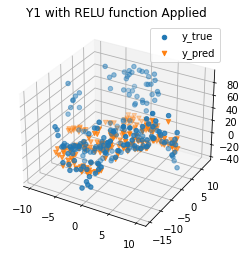

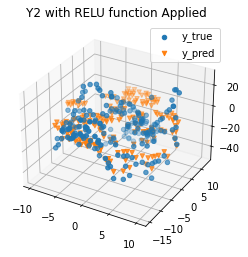

In [28]:
# Replotting the sample with y_true and y_pred
plot_3d(2, 'Y1 with RELU function Applied', X, y_true[:,0], y_pred[:,0])
plot_3d(2, 'Y2 with RELU function Applied', X, y_true[:,1], y_pred[:,1])